# LightGBM tuning
Goal: tune a LightGBM model.
<br>Learn more about the algorithm [here](https://lightgbm.readthedocs.io/en/latest/#).
***

## Table of Contents 

1. [Intuition Behind Tuning Approach](#1.-Intuition-Behind-Tuning-Approach)
2. [Intuition Behind Evaluation Metrics](#2.-Intuition-Behind-Tuning-Metrics)
3. [Load Data](#3.-Load-Data)
4. [Define Functions](#4.-Define-Functions)
5. [Building a Baseline Model](#5.-Building-a-Baseline-Model)
6. [Equalize Class Imbalance](#6.-Equalize-Class-Imbalance)
7. [Control Overfitting](#7.-Control-Overfitting)
<br>7.1 [Parameters num_leaves, min_child_samples, max_depth, and min_child_weight](#7.1-Parameters-num_leaves,-min_child_samples,-max_depth,-and-min_child_weight)
<br>7.2 [Parameters subsample, subsample_freq, colsample_bytree, and max_depth](#7.2-Parameters-subsample,-subsample_freq,-colsample_bytree,-and-max_depth)
<br>7.3 [Parameters learning_rate, n_estimators, and max_bin](#7.3-Parameters-learning_rate,-n_estimators,-and-max_bin)
8. [Regularization](#8.-Regularization)
<br>8.1 [Parameters reg_alpha, reg_lambda, and min_split_gain](#8.1-Parameters-reg_alpha,-reg_lambda,-and-min_split_gain)
9. [Iteration Comparisons](#9.-Iteration-Comparisons)
10. [Final Model](#10.-Final-Model)
11. [Additional Reference](#11.-Additional-Reference)
***

## 1. Intuition Behind Tuning Approach
1. **Build a baseline model** to measure efficacy of parameter tuning for evaluation metric improvements.
2. **Equalize the class imbalance** to get a more reliable evaluation of model performance.
3. **Control overfitting** and tune parameters for the leaf-wise (best-first) tree.
4. **Regularize** predictions.
***

## 2. Intuition Behind Evaluation Metrics
Click this [link](https://github.com/ayn28/churn-prediction-modeling/blob/master/model-tuning/XGBoost-tuning.ipynb) or copy and paste the link below into your browser to read about the intuition behind choosing the evaluation metrics. 

https://github.com/ayn28/churn-prediction-modeling/blob/master/model-tuning/XGBoost-tuning.ipynb
***

## 3. Load Data

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Import cleaned datasets
df = pd.read_csv('data/cleaned_data/og_cleaned_samples.csv', index_col='customerID')
df_cat_encoded = pd.read_csv('data/cleaned_data/num_cleaned_samples.csv', index_col='customerID')

# Create features and target arrays
X = df_cat_encoded.drop(['Churn_Yes', 'gender_Male'], axis=1).values
y = df_cat_encoded.Churn_Yes.values

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

To create our features array, we drop the Churn feature since that is our target variable and we are trying to predict its labels. From our EDA, we determined that a customer's gender likely has no effect on their propensity to churn since it wasn't strongly correlated with other features and had no notable differences in churn rates between genders.
***

### 4. Define Functions

In [3]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Define function to fit a classifier.
def fit_model(clf_name):
    """Fit a classifier to the training data."""
    clf_name.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc'],    # Will document logloss (by default) and AUC
        early_stopping_rounds=10,
        verbose=False
    )

# Define function to calculate evaluation metrics.
def metrics(clf_name, ordered_dict):
    """Calculate and output evaluation metrics."""
    # Print best iteration round number
    best_iteration = clf_name.best_iteration_
    # Calculate AUC, AUCPR, and Logloss
    auc_mtr = [i for i in clf_name.best_score_.values()][0]['auc']
    logloss_mtr = [i for i in clf_name.best_score_.values()][0]['binary_logloss']
    # Calculate AUCPR
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    aucpr_mtr = average_precision_score(y_test, preds)
    print('Best iteration: {} rounds.'.format(best_iteration))
    print('AUC:       {0:.3f}'.format(auc_mtr))
    print('AUCPR:     {0:.3f}'.format(aucpr_mtr))
    print('Logloss:   {0:.3f}'.format(logloss_mtr))
    # Calculate precision, recall, and f1-score
    binary_preds = clf_name.predict(X_test)
    print('Precision: {0:.3f}'.format(precision_score(y_test, binary_preds)))
    print('Recall:    {0:.3f}'.format(recall_score(y_test, binary_preds)))
    print('F1-score:  {0:.3f}'.format(f1_score(y_test, binary_preds)))
    # Append metrics to an ordered dictionary (for plotting)
    ordered_dict['Best_iteration'] = best_iteration
    ordered_dict['AUC'] = round(auc_mtr, 3)
    ordered_dict['AUCPR'] = round(aucpr_mtr, 3)
    ordered_dict['Logloss'] = round(logloss_mtr, 3)
    ordered_dict['Precision'] = round(precision_score(y_test, binary_preds), 3)
    ordered_dict['Recall'] = round(recall_score(y_test, binary_preds), 3)
    ordered_dict['F1_score'] = round(f1_score(y_test, binary_preds), 3)
    
# Define function to plot ROC curve.     
def plot_roc(clf_name):
    """Plot the ROC curve for a given classifier."""
    # Calculate the fpr and tpr for all thresholds of the classification
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure(figsize=(7, 7))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Define function to plot PR curve.
def plot_pr(clf_name):
    """Plot the precision-recall curve for a given classifier."""
    # Calculate the precision and recall for all thresholds of the classification
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    average_precision = average_precision_score(y_test, preds)
    # Plot PR curve
    plt.figure(figsize=(7, 7))
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label='AUCPR = %0.3f' % average_precision)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0.5, 0.5],'r--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()

# Define function to plot ROC and PR curve.
def plot_roc_pr(clf_name):
    """Plot the ROC and PR-curve for a given classifier."""
    plt.figure(figsize=(14, 7))
    # Plot ROC
    plt.subplot(121)
    probs = clf_name.predict_proba(X_test)
    preds = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.3f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    # Plot PR curve
    plt.subplot(122)
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    average_precision = average_precision_score(y_test, preds)
    plt.title('Precision-Recall Curve')
    plt.plot(recall, precision, 'b', label='AUCPR = %0.3f' % average_precision)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0.5, 0.5],'r--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()
    
# Define function to plot metric changes between consecutive iterations.
def plot_consec_metric_delta(label1, dict1, label2, dict2):
    """Plot the metric changes between consecutive iterations."""
    df = pd.DataFrame(
        data=[[val for (metric, val) in dict1.items()],
              [val for (metric, val) in dict2.items()]],
        columns=[metric for (metric, val) in dict1.items()]
    )
    
    # Store best iterations
    bst_iters = list(df['Best_iteration'])
    
    # Drop the 'Best_iteration' column inplace
    df.drop(['Best_iteration'], axis=1, inplace=True)
    
    # Define # of iterations you want to plot
    N = 2
    ind = np.arange(N)    
    
    # Plot metrics
    plt.figure(figsize=(6, 6))
    for metric in list(df.columns):
        plt.plot(ind, df[metric].values, linewidth=1.5, marker='o', label=metric);
    
    plt.xticks(
        ticks=np.arange(N),
        labels=[
            '{}\n{} rounds'.format(label1, bst_iters[0]),
            '{}\n{} rounds'.format(label2, bst_iters[1])
        ])
    
    # Fixed
    plt.title('Evaluation Metrics Over Consecutive Iterations', fontsize=13)
    plt.ylabel('Value', fontsize=12)
    plt.xlabel('Iteration', fontsize=12)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
    plt.show()

### 5. Building a Baseline Model
In order to get an idea of the range of precision and recall we would like our model to surpass, we are going to build a baseline model and save its score for later. This score is what we can achieve with no tuning. 

In [6]:
import lightgbm as lgb

# Define baseline parameters
params = {
    'verbosity': 0,
    'seed': 42,
    'objective': 'binary'
}

# Instantiate a classifier (using all default parameters)
clf_baseline = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf_baseline)

# Output evaluation metrics
clf_baseline_dict = OrderedDict()
metrics(clf_baseline, clf_baseline_dict)

Best iteration: 14 rounds.
AUC:       0.841
AUCPR:     0.631
Logloss:   0.435
Precision: 0.684
Recall:    0.390
F1-score:  0.497


With the model's parameters set to their default values and no tuning, we get the baseline metric scores listed above. Let's tweak a few parameters and potentially increase our baseline scores.
***

### 6. Equalize Class Imbalance
Setting the scale_pos_weight parameter to the ratio of negative-to-positive classes will help equalize the class imbalance. It's acceptable to now use AUC for model evaluation since the ROC curve is less weighted towards the true negatives thereby providing a less biased representation of the model's performance.

In [7]:
# Load data into Dataset objects (optimized for LightGBM)
# (very memory-efficient b/c it only saves discrete bins)
dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(X_test, label=y_test)

# Balance the positive and negative weights and assign it to the scale_pos_weight parameter
train_labels = dtrain.get_label()
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
print('Value for scale_pos_weight: {:.2f}'.format(ratio))

Value for scale_pos_weight: 2.76


In [8]:
# Set hyperparameters
# (added the scale_pos_weight parameter)
params = {
    'verbosity': 0,
    'seed': 42,
    'objective': 'binary',
    'scale_pos_weight': 2.76
}

# Instantiate classifier
clf_equalize = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf_equalize)

# Output evaluation metrics 
clf_equalize_dict = OrderedDict()
metrics(clf_equalize, clf_equalize_dict)

Best iteration: 14 rounds.
AUC:       0.837
AUCPR:     0.635
Logloss:   0.469
Precision: 0.552
Recall:    0.742
F1-score:  0.633


Rebalancing the class weights effected our model's evaluation metrics, especially recall. Let's compare the baseline model to the equalized model and further analyze the changes.

Baseline model:
Best iteration: 14 rounds.
AUC:       0.841
AUCPR:     0.631
Logloss:   0.435
Precision: 0.684
Recall:    0.390
F1-score:  0.497

Equalized model:
Best iteration: 14 rounds.
AUC:       0.837
AUCPR:     0.635
Logloss:   0.469
Precision: 0.552
Recall:    0.742
F1-score:  0.633


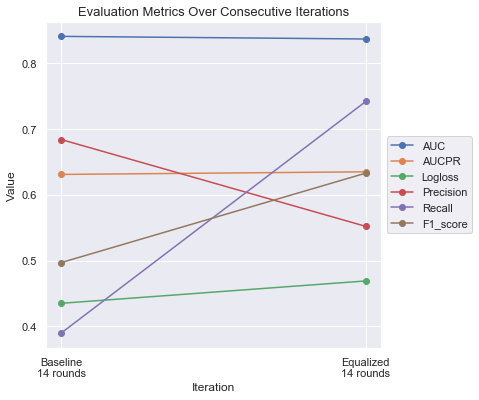

In [10]:
# Print evaluation metrics for baseline model
print('Baseline model:')
metrics(clf_baseline, clf_baseline_dict)

# Print evaluation metrics for equalized model
print('\nEqualized model:')
metrics(clf_equalize, clf_equalize_dict)

# Plot the changes between both iterations
plot_consec_metric_delta('Baseline', clf_baseline_dict, 'Equalized', clf_equalize_dict)

After balancing the classes, the tuned classifier's ability to find all positive samples increases - represented by an increase in recall - at the expense of labeling more negative samples as positive - represented by a decrease in precision. The tradeoff of a lower precision isn't entirely undesireable here since the f1-score increased - which is the harmonic mean of precision and recall. The f1-score gives equal weight to both measures and is useful to create a classification model with an optimal balance of precision and recall.
***

## 7. Control Overfitting
According to the LightGBM documentation:
<br><br>"LightGBM uses the leaf-wise tree growth algorithm, while many other popular tools use depth-wise tree growth. Compared with depth-wise growth, the leaf-wise algorithm can converge much faster. However, the leaf-wise growth may be over-fitting if not used with the appropriate parameters.

### 7.1 Parameters num_leaves, min_child_samples, max_depth, and min_child_weight
* **num_leaves**: Max number of leaves in one tree. This is the main parameter to control the complexity of the model.
* **min_child_samples**: Minimal number of data in one leaf. This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. 
* **max_depth**: Limit the max depth for tree model. This is used to deal with over-fitting when data is small. 
* **min_child_weight**: Minimal sum hessian in one leaf used to deal with over-fitting.

In [60]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time 

# Set hyperparameters
params = {
    'verbosity': 0,
    'seed': 42,
    'objective': 'binary',
    'scale_pos_weight': 2.76
}

# Parameters to tune 
params_grid = {
    'num_leaves': np.arange(2, 124, 2),
    'min_child_samples': np.arange(1, 50, 1),
    'max_depth': np.arange(-1, 50, 2),
    'min_child_weight': np.arange(1, 50, 1)
}

# Peform RandomizedSearchCV to find optimal params
clf_of1_grid = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(**params),
    param_distributions=params_grid,     # RS=param_distributions=; GS=param_grid
    n_iter=150,                          # NO n_iter for GS
    n_jobs=1,                            # NO n_jobs for GS
    scoring='roc_auc',
    cv=5,
    verbose=1
)

# Fit the model
%time clf_of1_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(clf_of1_grid.best_score_))
print('Testing the following params:')
for key, val in clf_of1_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 13min 3s, sys: 20.8 s, total: 13min 24s
Wall time: 2min 3s
Best AUC score: 0.850
Testing the following params:
	num_leaves: 4
	min_child_weight: 7
	min_child_samples: 44
	max_depth: 33


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:  2.1min finished


Best iteration: 15 rounds.
AUC:       0.831
AUCPR:     0.598
Logloss:   0.497
Precision: 0.509
Recall:    0.740
F1-score:  0.603


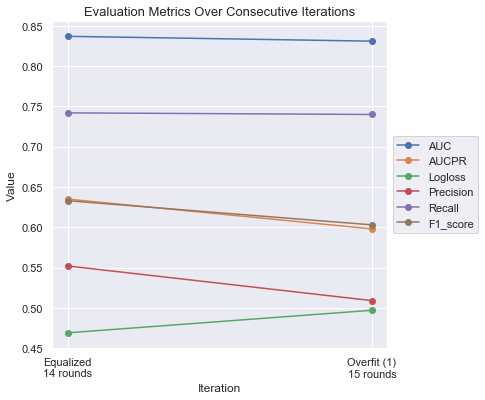

In [11]:
params = {
    'verbosity':         0,
    'seed':              42,
    'objective':        'binary',
    'scale_pos_weight':  2.76,
    'num_leaves':        4,
    'min_child_weight':  7,
    'min_child_samples': 44,
    'max_depth':         33
}

# Instantiate classifier
clf_of1 = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf_of1)

# Output eval metrics
clf_of1_dict = OrderedDict()
metrics(clf_of1, clf_of1_dict)
plot_consec_metric_delta('Equalized', clf_equalize_dict, 'Overfit (1)', clf_of1_dict)

In the first iteration of controlling overfitting and tree complexity: AUCPR, f1-score, and precision **decreased** whereas logloss **increased**. Limiting the tree complexity reduced the model's ability to classify the relevant "churn" data points - shown by a decrease in precision, which also accounts for the decrease in AUCPR, f1-score, and logloss.

### 7.2 Parameters subsample, subsample_freq, colsample_bytree, and max_depth
These parameters control the sampling of the dataset that is done at each boosting round and add randomness to make training robust to noise to control overfitting.
* **subsample**: Use bagging and feature subsampling to randomly select part of data without resampling. Can be used to speed up training and deal with overfitting.
* **subsample_freq**: Frequency for bagging (subsample).
* **colsample_bytree**: LightGBM will randomly select part of features on each iteration. Can be used to speed up training and deal with overfitting.
* **max_depth**: Limit the max depth for tree model (tune max_depth in this iteration as well).

In [85]:
# Fixed params
params = {
    'verbosity':         0,
    'seed':              42,
    'objective':        'binary',
    'scale_pos_weight':  2.76,
    'num_leaves':        4,
    'min_child_weight':  7,
    'min_child_samples': 44
}

# Parameters to tune 
params_grid = {
    'subsample': np.arange(.1, 1.1, .1),
    'subsample_freq': np.arange(1, 16, 1),
    'colsample_bytree': np.arange(.1, 1.1, .1),
    'max_depth': np.arange(-1, 50, 2)
}

# Peform RandomizedSearchCV to find optimal params
clf_of2_grid = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(**params),
    param_distributions=params_grid,     
    n_iter=150,                          
    n_jobs=1,                            
    scoring='roc_auc',
    cv=5,
    verbose=1
)

# Fit the model
%time clf_of2_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(clf_of2_grid.best_score_))
print('Testing the following params:')
for key, val in clf_of2_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 4min 42s, sys: 10.4 s, total: 4min 52s
Wall time: 49 s
Best AUC score: 0.853
Testing the following params:
	subsample_freq: 10
	subsample: 0.6
	max_depth: 3
	colsample_bytree: 0.2


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:   48.9s finished


Best iteration: 40 rounds.
AUC:       0.841
AUCPR:     0.639
Logloss:   0.498
Precision: 0.501
Recall:    0.813
F1-score:  0.620


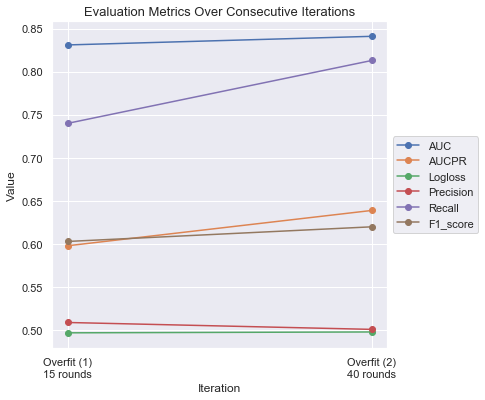

In [12]:
params = {
    'verbosity':         0,
    'seed':              42,
    'objective':        'binary',
    'scale_pos_weight':  2.76,
    'num_leaves':        4,
    'min_child_weight':  7,
    'min_child_samples': 44,
    'subsample_freq':    10,
    'subsample':         0.6,
    'max_depth':         3,
    'colsample_bytree':  0.2
}

# Instantiate classifier
clf_of2 = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf_of2)

# Output eval metrics
clf_of2_dict = OrderedDict()
metrics(clf_of2, clf_of2_dict)
plot_consec_metric_delta('Overfit (1)', clf_of1_dict, 'Overfit (2)', clf_of2_dict)

In the second iteration of controlling overfitting and tree complexity, only **precision decreased**. The increased model performance is mainly attributed to bagging and decreasing the tree depth to further control overfitting. The tuning parameters in this iteration increased the training speed by 50%. 

### 7.3 Parameters learning_rate, n_estimators, and max_bin
The learning_rate parameter is used shrink the feature weights after each boosting round; it defines the amount of "correction" we make at each step to prevent overfitting. In practice, having a lower learning rate makes our model more robust to overfitting, thus, the lower the learning_rate the better. However, with a lower learning rate we need more boosting rounds - which corresponds to more trees (n_estimators). Both of these parameters add randomness to make training robust to noise to control overfitting.
* **learning_rate**: Shrinkage rate.
* **n_estimators**: Number of boosting iterations. 
* **max_bin**: Max number of bins that feature values will be bucketed in; small number of bins may reduce training accuracy but may increase general power to deal with overfitting. 

In [87]:
# Fixed params
params = {
    'verbosity':         0,
    'seed':              42,
    'objective':        'binary',
    'scale_pos_weight':  2.76,
    'num_leaves':        4,
    'min_child_weight':  7,
    'min_child_samples': 44,
    'subsample_freq':    10,
    'subsample':         0.6,
    'max_depth':         3,
    'colsample_bytree':  0.2
}

# Parameters to tune 
params_grid = {
    'learning_rate': [0.0005, 0.005, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8],
    'n_estimators': np.arange(25, 1025, 25),
    'max_bin': np.arange(10, 510, 10)
}

# Peform RandomizedSearchCV to find optimal params
clf_of3_grid = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(**params),
    param_distributions=params_grid,     
    n_iter=600,                          
    n_jobs=1,                            
    scoring='roc_auc',
    cv=5,
    verbose=1
)

# Fit the model
%time clf_of3_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(clf_of3_grid.best_score_))
print('Testing the following params:')
for key, val in clf_of3_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 1h 7min 48s, sys: 2min, total: 1h 9min 48s
Wall time: 11min 20s
Best AUC score: 0.853
Testing the following params:
	n_estimators: 275
	max_bin: 20
	learning_rate: 0.05


[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed: 11.3min finished


Best iteration: 40 rounds.
AUC:       0.837
AUCPR:     0.623
Logloss:   0.507
Precision: 0.523
Recall:    0.765
F1-score:  0.621


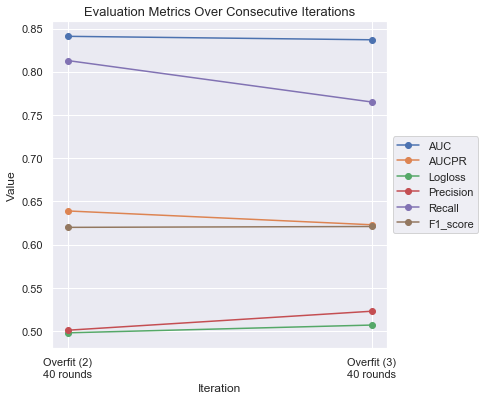

In [13]:
params = {
    'verbosity':         0,
    'seed':              42,
    'objective':        'binary',
    'scale_pos_weight':  2.76,
    'num_leaves':        4,
    'min_child_weight':  7,
    'min_child_samples': 44,
    'subsample_freq':    10,
    'subsample':         0.6,
    'max_depth':         3,
    'colsample_bytree':  0.2,
    'n_estimators':      275,
    'learning_rate':     .05,
    'max_bin':           20       
}

# Instantiate classifier
clf_of3 = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf_of3)

# Output eval metrics
clf_of3_dict = OrderedDict()
metrics(clf_of3, clf_of3_dict)
plot_consec_metric_delta('Overfit (2)', clf_of2_dict, 'Overfit (3)', clf_of3_dict)

In the third iteration of controlling overfitting, we shrink the feature weights after each boosting round and as a result, the **recall score dropped**. 
***

## 8. Regularization
Regularization aims to reduce the variance of a model without increasing its bias.
### 8.1 Parameters reg_alpha, reg_lambda, and min_split_gain
* **reg_alpha**: L1 regularization; adds a penalty equal to the sum of the absolute value of the coefficients.
* **reg_lambda** L2 regularization; adds a penalty equal to the sum of the squared value of the coefficients.
* **min_split_gain**: The minimal gain to perform split.

In [17]:
params = {
    'verbosity':         0,
    'seed':              42,
    'objective':        'binary',
    'scale_pos_weight':  2.76,
    'num_leaves':        4,
    'min_child_weight':  7,
    'min_child_samples': 44,
    'subsample_freq':    10,
    'subsample':         0.6,
    'max_depth':         3,
    'colsample_bytree':  0.2,
    'n_estimators':      275,
    'learning_rate':     .05,
    'max_bin':           20       
}

# Parameters to tune 
params_grid = {
    'reg_alpha': np.arange(0, 20, 1),
    'reg_lambda': np.arange(0, 20, 1),
    'min_split_gain': np.arange(0, 30, 1)
}

# Peform RandomizedSearchCV to find optimal params
clf_reg_grid = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(**params),
    param_distributions=params_grid,     
    n_iter=600,                          
    n_jobs=1,                            
    scoring='roc_auc',
    cv=5,
    verbose=1
)

# Fit the model
%time clf_reg_grid.fit(X_train, y_train)

print('Best AUC score: {0:.3f}'.format(clf_reg_grid.best_score_))
print('Testing the following params:')
for key, val in clf_reg_grid.best_params_.items():
    print('\t{}: {}'.format(key, val))

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 25min 41s, sys: 45.2 s, total: 26min 26s
Wall time: 4min 13s
Best AUC score: 0.853
Testing the following params:
	reg_lambda: 8
	reg_alpha: 0
	min_split_gain: 1


[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:  4.2min finished


Best iteration: 40 rounds.
AUC:       0.837
AUCPR:     0.622
Logloss:   0.508
Precision: 0.526
Recall:    0.763
F1-score:  0.623


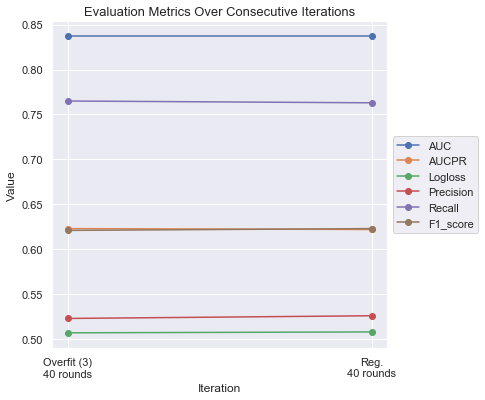

In [19]:
params = {
    'verbosity':         0,
    'seed':              42,
    'objective':        'binary',
    'scale_pos_weight':  2.76,
    'num_leaves':        4,
    'min_child_weight':  7,
    'min_child_samples': 44,
    'subsample_freq':    10,
    'subsample':         0.6,
    'max_depth':         3,
    'colsample_bytree':  0.2,
    'n_estimators':      275,
    'learning_rate':     .05,
    'max_bin':           20,
    'reg_lambda':        8,
    'reg_alpha':         0,
    'min_split_gain':    1
}

# Instantiate classifier
clf_reg = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf_reg)

# Output eval metrics
clf_reg_dict = OrderedDict()
metrics(clf_reg, clf_reg_dict)
plot_consec_metric_delta('Overfit (3)', clf_of3_dict, 'Reg.', clf_reg_dict)

The optimal regularization parameters didn't significantly change the model's evaluation metrics - given the minimal penalties applied to the predictions. 
***

## 9. Iteration Comparisons

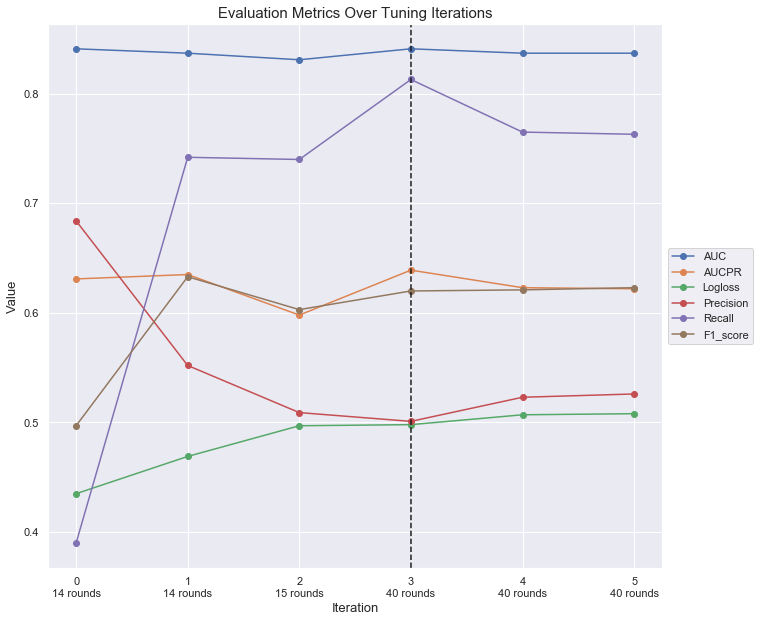

In [21]:
df_final = pd.DataFrame(
    data=[[val for (metric, val) in clf_baseline_dict.items()],
          [val for (metric, val) in clf_equalize_dict.items()],
          [val for (metric, val) in clf_of1_dict.items()],
          [val for (metric, val) in clf_of2_dict.items()],
          [val for (metric, val) in clf_of3_dict.items()],
          [val for (metric, val) in clf_reg_dict.items()]
         ],
    columns=[metric for (metric, val) in clf_baseline_dict.items()]
    )

# Store best iterations
bst_iters_final = list(df_final['Best_iteration'])

# Drop the 'Best_iteration' column inplace
df_final.drop(['Best_iteration'], axis=1, inplace=True)

# Define # of iterations you want to plot
N = len(df_final.columns)
ind = np.arange(N)    

# Plot metrics
plt.figure(figsize=(11, 10))
for metric in list(df_final.columns):
    plt.plot(ind, df_final[metric].values, linewidth=1.5, marker='o', label=metric);

plt.axvline(x=3, color='k', linestyle='--')

plt.xticks(
    ticks=np.arange(N),
    labels=[
        '0\n{} rounds'.format(bst_iters_final[0]),
        '1\n{} rounds'.format(bst_iters_final[1]),
        '2\n{} rounds'.format(bst_iters_final[2]),
        '3\n{} rounds'.format(bst_iters_final[3]),
        '4\n{} rounds'.format(bst_iters_final[4]),
        '5\n{} rounds'.format(bst_iters_final[5]),
    ])

# Fixed
plt.title('Evaluation Metrics Over Tuning Iterations', fontsize=15)
plt.ylabel('Value', fontsize=13)
plt.xlabel('Iteration', fontsize=13)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

**The LightGBM model performs best at the third iteration.**
* By the third iteration:
    * the imbalanced classes have been equalized,
    * the tree complexity was controlled to reduce overfitting,
    * and used bagging to add randomness to make training robust to noise and further reduce overfitting. 
* At this iteration, the model has:
    * Highest recall, AUC, and AUCPR with a good f1-score relative to other iterations.
***

## 10. Final Model

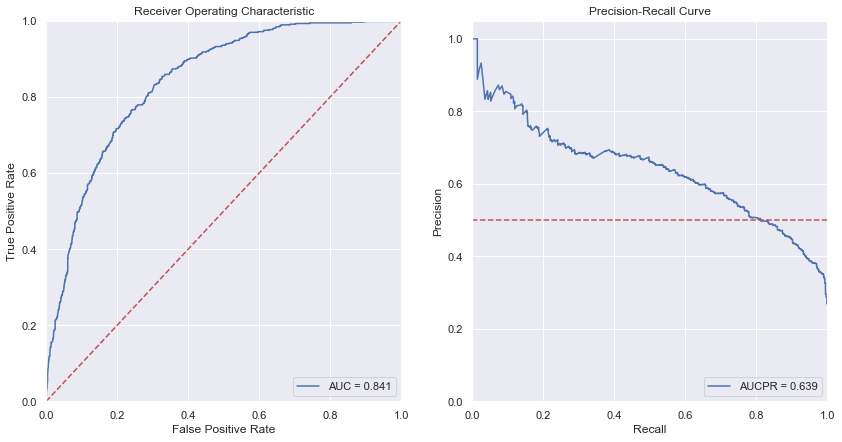

Best iteration: 40 rounds.
AUC:       0.841
AUCPR:     0.639
Logloss:   0.498
Precision: 0.501
Recall:    0.813
F1-score:  0.620


In [126]:
# Final parameters
params = {
    'verbosity':         0,
    'seed':              42,
    'objective':        'binary',
    'scale_pos_weight':  2.76,
    'num_leaves':        4,
    'min_child_weight':  7,
    'min_child_samples': 44,
    'subsample_freq':    10,
    'subsample':         0.6,
    'max_depth':         3,
    'colsample_bytree':  0.2
}

# Instantiate classifier
clf_of2 = lgb.LGBMClassifier(**params)

# Fit classifier
fit_model(clf_of2)

# Output eval metrics
plot_roc_pr(clf_of2)
metrics(clf_of2, clf_of2_dict)

## 11. Additional Reference

In [ ]:
# # Logloss = -log(1/N) where N equals the number of classes.
# # It's well know a that a logloss of 0.693 is the 
# # non-informative binary logarithmic loss (i.e. random guessing).

# # Binary classes
# N = 2

# naive_logloss = round(-(np.log(1/2)), 3)
# print('Value for naive logloss: ', naive_logloss)